<a href="https://colab.research.google.com/github/pauloigorms/covid-twitter-pecd/blob/main/Programacao_Ciencia_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROGRAMAÇÃO PARA CIÊNCIA DE DADOS**

**Equipe**: Cássio de Paula / Paulo Moraes [(website)](https://paulomoraes.me).

**Objetivo**: analisar as mensagens
trocadas por usuários do Twitter sobre a COVID-19, com o intuito de realizar uma análise
exploratória e visualização de dados, passando também pelas etapas de limpeza e organização.
Mais especificamente, as equipes devem explorar a análise nas perguntas (questões) dos usuários,
pois arguimos que seja um tipo de mensagem apropriado para se compreender as principais dúvidas
das pessoas sobre a atual pandemia.


# **INFORMAÇÕES GERAIS**

### **ARTEFATOS**


*   Relatório Técnico - *Um notebook com o texto e o código-fonte apresentado na ferramenta Google COLAB*; 
*   Repositório no GitHub.


### **ATIVIDADES**


*   Importar base de dados;
*   Tratar base de dados;
*   Identificar as perguntas (questões) descritas nas mensagens;
*   Salvar coleção com a identificação das perguntas em um novo dataset chamado "DuvidasDB".


### **DO RESULTADO**


1.   Devem apresentar um resumo (sumário) com as estatísticas dos dados originais, elas podem ser apresentadas através de tabelas e/ou gráficos;
2.   Com a coleção resultando da identificação das perguntas a equipe deve apresentar as estatísticas sobre estes dados.


### **TEMAS DISCUTIDOS**

As equipes devem fazer uma análise sobre os temas que são debatidos nas perguntas dos postadas pelos usuários. Faça uma análise se as perguntas são relativas aos seguintes temas:

*   Doença. Quando a pergunta é relativa à doença Deve-se observar que a doença é identificada por vários nomes. Exemplo: coronavírus, corona, COVID-19, etc;
*   Medicamento. Quando a pergunta é sobre o uso de determinado medicamento no tratamento da doença;
*   Organizações. Quando a pergunta é relativa a uma determinada entidade ou organização. Emissora de TV, Ministério da Saúde ou empresas são exemplos de organizações;
*   Pessoas. Quando a pergunta é sobre determinada pessoa. Por exemplo, a pergunta pode ser sobre a atuação que determinado político ou pessoa famosa teve durante esse período de pandemia.

# **VISÃO DOS DADOS**

> **Visão Temporal** - Deve-se fazer uma análise temporal das perguntas que formam o dataset *DuvidasDB*. Pode-se considerar o intervalo temporal de dias, semanas ou meses. A escolha do intervalo de tempo ficará a cargo das equipes. Exemplos de análise temporal: a) houve um aumento no número de perguntas
ao longo do tempo? b) houve uma mudança no perfil das perguntas ao longo do tempo?

> **Visão Geográfica** - Deve-se fazer uma análise geográfica (espacial) das perguntas que formam o dataset *DuvidasDB*. Existem algumas colunas no dataset que trazem a informação das localizações como, por exemplo, o país, estado e cidade. Em alguns tuítes é possível ainda identificar as coordenadas geográficas
de latitude e longitude. Exemplo de análise geográfica: a) os usuários de regiões diferentes fazem
perguntas com diferentes focos? Por exemplo, será que os usuários de uma região perguntam mais
sobre a doença ou sobre o tratamento? Essa análise ainda pode ser realizada em diversos níveis de
área (cidade, estado ou região). Além de apresentar a distribuição das dúvidas dos usuários por
região, a equipe deverá fazer uma análise dessa distribuição. Por exemplo, apresentar as razões
(ou hipóteses) da ocorrência dessa distribuição.


# **INICIANDO O PROJETO**

IMPORTANDO LIBS

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

import nltk as nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from nltk.stem import rslp

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

from wordcloud import WordCloud, ImageColorGenerator
from sklearn.decomposition import PCA

import re as rexpression
from string import punctuation
import unicodedata

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


LEITURA DO ARQUIVO DE DADOS BASE

In [42]:
drive.mount('/content/drive')
load_data = pd.read_csv('drive/My Drive/twitter/dados-curso-completo.csv', sep= ',',skiprows=0, encoding='utf-8')
duvidas_file = pd.read_csv('drive/My Drive/twitter/duvidasdb.csv', sep= ',',skiprows=0, encoding='utf-8')
raw_data = load_data.drop_duplicates(['texto'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Funções

Função: **Cálcular Percente**

In [11]:
def percentual(value, total): 
    if not value and not total: 
       return print("value = 0% \n total = 0%") 
    elif value < 0 or total < 0: 
       return print("não aceita valor negativo!") 
    else: 
       return '{0:.2f}%'.format((value / total * 100))

Função: **Formatar para configuração decimal**

In [12]:
def decimaled(value):
  value = float('{:.3g}'.format(value))
  size = 0
  while abs(value) >= 1000:
    size += 1
    value /= 1000.0
  return '{}{}'.format('{:f}'.format(value).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][size])

Função: **Tokenização**

In [13]:
 def tokenize(sentence):
  words = sentence.split()
  tclean = []
  for word in words:
    nfkd = unicodedata.normalize('NFKD', word)
    noaccent = u''.join([r for r in nfkd if not unicodedata.combining(r)])
    join = rexpression.sub('[^a-zA-Z \\\]',' ', noaccent)
    tclean.append(join.lower().strip())
  return ' '.join([r for r in tclean if len(r) > 1 and not r.isdigit()])

Função: **Remover stopwords**

In [14]:
def rm_stopwords(sentence):
  words = sentence.split()
  swords = stopwords.words('portuguese')
  return [r for r in words if r.lower().strip() not in swords] 

Função: **Reduzir as palavras ao seu radical**

In [15]:
def stemming(words):
  stm = []
  for word in words:
    stm.append(rslp.RSLPStemmer().stem(word))
  return stm

Função: **Mineração de texto**

In [16]:
def mining_text(frame):
  result = []
  for index, question in frame.iterrows():
    item = tokenize(question.Perguntas)
    item = rm_stopwords(item)
    item = stemming(item)
    result = result + item
  return result

#Estatísticas bases


**Exemplo da base de dados**

---



In [37]:
raw_data.head(1)

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
data,,,,,,,,,,,,,
2020-03-23 18:51:14,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado??? Congres...,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]


**Tamanha da base (com e sem dados duplicados)**

---

In [28]:
print("Total de dados (com duplicados): ", decimaled(load_data.texto.count()), " completo[", load_data.texto.count(), "]" )

Total de dados (com duplicados):  1.66M  completo[ 1658825 ]


In [29]:
print("Total de dados (sem duplicados): ", decimaled(raw_data.texto.count()), " completo[", raw_data.texto.count(), "]" )

Total de dados (sem duplicados):  1.65M  completo[ 1653599 ]


**Twitters por região**

---

In [35]:
print("Total de twitters com localização: ", decimaled(raw_data['lugar'].count()), " completo[", raw_data['lugar'].count(),"]")

Total de twitters com localização:  74.4K  completo[ 74383 ]


In [31]:
print("Percentual em relação à base: ", percentual(value=raw_data['lugar'].count(), total=raw_data.texto.count()))

Percentual em relação à base:  4.50%


In [43]:
raw_data[raw_data.pais == 'Brazil'].groupby('pais').count()

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,sigla,latitude,longitude,hashtags
pais,,,,,,,,,,,,
Brazil,67034,67033,67034,67034,67034,67034,67034,67034,67034,7675,7675,67034


In [44]:
raw_data[raw_data.pais == 'Brazil'].groupby(['pais', 'lugar']).count().tail(2)

data  usuario  apelido  ...  latitude  longitude  hashtags
pais   lugar                                  ...                               
Brazil Érico Cardoso     1        1        1  ...         1          1         1
       Óbidos            2        2        2  ...         0          0         2

[2 rows x 11 columns]

**Twitters por período**

---

In [38]:
df_data = pd.DataFrame(raw_data)
df_data['data'] = pd.to_datetime(df_data['data'])
df_data.index = df_data['data']
df_data.drop('data', inplace=True, axis=1)

df_res = df_data.resample('M').count()
df_res.reset_index(inplace=True)

df_res

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-01-31,54388,54391,54391,54391,54391,54391,2177,2177,2177,80,80,54391
1,2020-02-29,109485,109489,109489,109489,109489,109489,4305,4305,4305,225,225,109489
2,2020-03-31,480112,480128,480128,480128,480128,480128,23487,23486,23484,2561,2561,480128
3,2020-04-30,469321,469334,469334,469334,469334,469334,21318,21317,21315,2516,2516,469334
4,2020-05-31,283219,283229,283229,283229,283229,283229,12780,12777,12777,1993,1993,283229
5,2020-06-30,257022,257027,257027,257027,257027,257027,10316,10316,10315,1345,1345,257027
6,2020-07-31,1,1,1,1,1,1,0,0,0,0,0,1


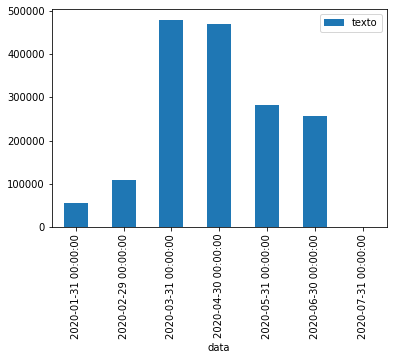

In [40]:
df_res.plot(kind='bar',x='data',y='texto')

**Twitters por Hashtag**

---

In [85]:
raw_data[raw_data.pais == "Brazil"].groupby('hashtags').count().head(5)

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude
hashtags,,,,,,,,,,,,
['100vezesgauchão'],1,1,1,1,1,1,1,1,1,1,0,0
"['1290am', 'ZilhõesDeCoisas']",1,1,1,1,1,1,1,1,1,1,0,0
"['14Abril', 'apocalypse2020', 'auxiloemergencial']",1,1,1,1,1,1,1,1,1,1,0,0
"['1milhaodemortos', 'BolsonaroGenocida', 'ParabensBolsonaro']",1,1,1,1,1,1,1,1,1,1,0,0
['2019_nCoV'],1,1,1,1,1,1,1,1,1,1,0,0


In [87]:
ex = raw_data[raw_data.hashtags.str.contains("BolsonaroGenocida")].count()
ex

data          857
usuario       857
apelido       857
texto         857
retweet       857
seguidores    857
idioma        857
lugar          43
pais           43
sigla          43
latitude        1
longitude       1
hashtags      857
dtype: int64

#Pré-processamento

**Mineração de Perguntas**


In [ ]:
sent_tokenize(raw_data['texto'][7159]) # this gives us a list of sentences

['@TeichNelson @minsaude @Medicina_CFM @Astro_Pontes Ajudar a enxergar coisas no raio-x, que indicaram algo como o vi… https://t.co/zPbNfdIHll']

*Mineração para Recuperação de Perguntas na Base*

Somente as perguntas

In [ ]:
#valor = len(raw_data.texto)
test = raw_data.head(5)
valor = len(test.texto)

In [ ]:
twitter = []
perguntas = []
erro = []
for i in range(0, len(raw_data)):
  try:
    twitter.append(sent_tokenize(raw_data[i]))   #twitter é uma lista de frases/sentenças
    for sentencas in twitter: #percorro todas as sentenças
      for row in sentencas:
        palavras = word_tokenize(row.lower()) #quebra a sentença em palavras e pontuações
        for palavra in palavras:
          if palavra == '?':
            perguntas.append([row,i]) 
            break #em uma senteça pode ter vario pontos de interrogação, então logo no primeiro '?' ele recupera a sentença e sai dessa iteração
    twitter.clear()#libera a lista de sentenças atual/ pois o objetivo era apenas percorrer o registro e não persistir o twitter a cada iteração 
  except:
    erro.append(i)

In [ ]:
questions = []

for index, twitter in raw_data.iterrows():
  if pd.notnull(twitter.texto):
    for sentence in sent_tokenize(twitter.texto):
      for word in word_tokenize(sentence.lower()):
        if word == '?':
          questions.append(sentence)
          break

Perguntas por twitter

In [ ]:
twitter = []
perguntas = []
erro = []
for i in range(0,100):
  try:
    twitter.append(sent_tokenize(raw_data['texto'][i]))   
    for sentencas in twitter: 
      flgPergunta = 0;
      for row in sentencas:
        palavras = word_tokenize(row.lower())
        for palavra in palavras:
          if palavra == '?':
            flgPergunta = 1;
            break
    if flgPergunta == 1:
      perguntas.append([raw_data['texto'][i],i])           
    twitter.clear()
  except:
    erro.append(i)

In [ ]:
perguntas

[]

Resumo

In [ ]:
print('Quantidade de registros que quebrariam a mineração: ', decimaled(len(erro)), 'completo[', len(erro), ']')

In [ ]:
print('Quantidade de perguntas extraída: ', decimaled(len(perguntas)), 'completo[', len(perguntas), ']')

**DataSet gerado para a análise**

In [ ]:
# df_DuvidasDB = pd.DataFrame(perguntas, columns=['Perguntas','Indice'])
# df_DuvidasDB.to_csv(r'drive/My Drive/twitter/duvidasdb.csv', index = False)
# df_DuvidasDB.head(1)
# question = df_DuvidasDB.Perguntas[1]
questions = " ".join(twitter for twitter in duvidas_file.Perguntas)

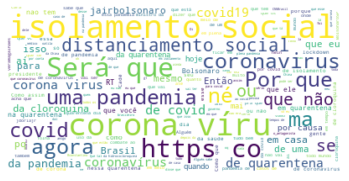

In [ ]:
wordcloud = WordCloud(background_color="white").generate(questions)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Processamento

In [ ]:
cloud_word = {
  'medicamentos' = ['cloroquina', 'hidroxicloroquina', 'cha de boldo', 'cha de alho', 'remdesivir', 'azitromicina']
  'pessoas' = ['bolsonaro', 'bolsonarosp', 'henrique mandetta', 'eduardo pazuello', 'jair bolsonaro', 'Nelson Teich', 'atila iamarino', 'paulo guedes']
  'doencas' = ['corona', 'corona virus', 'virus', 'pandemia', 'epidemia']
  'organizacoes' = ['globo', 'tvglobo', 'cnn', 'ministerio da saude', 'stf', 'estadao', 'folha de sao paulo', 'isto é','jovem pan', 'jp', 'jornal nacional', 'jornal do amazonas', 'jornal', 'tv', 'radio']
}
df_cloud_word = pd.DataFrame(data=cloud_word)

In [ ]:
short_data = duvidas_file.head(100)
short_text_processed mining_text(frame=short_data)

In [ ]:
text_processed = mining_text(frame=short_data)

NameError: ignored

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True)
vectorizer = vectorizer.fit_transform(text_processed)

In [ ]:
kmeans = KMeans(n_clusters=4, init = 'k-means++', max_iter = 30).fit(vectorizer)

In [ ]:
predict = kmeans.predict(vectorizer)

In [ ]:
labels = kmeans.labels_
distance = kmeans.fit_transform(vectorizer)

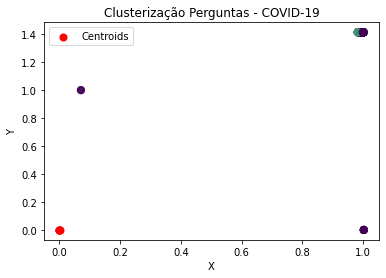

In [ ]:
plt.scatter(distance[:, 0], distance[:,1], s = 50, c = labels, alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 50, c = 'red', label = 'Centroids')
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, color = 'black', alpha=0.5)
plt.title('Clusterização Perguntas - COVID-19')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

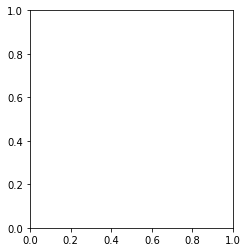

In [ ]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1)
pca = PCA(n_components=2, random_state= 0)
reduced_features = pca.fit_transform(vectorizer.toarray())
#reduced_cluster_centers = pca.transform(predict.cluster_centers_)